In [1]:
!pip install scikeras scikit-learn-intelex threadpoolctl -q

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from __future__ import print_function
from datetime import datetime

import string
import spacy
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,GridSearchCV

import tensorflow as tf   
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.python.keras import Sequential
from keras.layers import Embedding, LSTM, Dense,Dropout
from scikeras.wrappers import  KerasClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from keras.utils import to_categorical

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, f1_score,precision_score, recall_score

# Load data

In [3]:
df = pd.read_csv('../data/processed/drug_review_clean.csv', index_col= False)

# Preprocess

# Build a class to do preprocess
The dataframe contains different types of features: numericals ('mean_word_len','word_count', etc), categorical(eg.'rating_category','condidition','drugName'), and datetime ('date'). Also, The target of 'sentiment_label' is categorimcal. The preprocess including the following steps:

1.tokenizer the'review_clean' using keras Tokenizer
2. encode the categorical features and target 'sentiment_label'
3. extract the 'date' to several new features 'year','month','day'.
4.scale the numerical features using MinMaxScaler.
5. train test split

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_sequence_length=214):
        self.max_sequence_length = max_sequence_length
        self.tokenizer = None
    """ define a function to convert text to tokenizer """
    def fit(self, X, y=None):
        self.tokenizer = Tokenizer(num_words = 5000, lower = False)
        self.tokenizer.fit_on_texts(X)
        return self
    """ define a function to convert the review text into sequence """

    def transform(self, X):
        sequences = self.tokenizer.texts_to_sequences(X)
        return pad_sequences(sequences, maxlen= 200)


In [5]:
class NumericalScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.scaler = MinMaxScaler()
        self.scaler.fit(X)
        return self

    def transform(self, X):
        return self.scaler.transform(X)

In [6]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(X)
        return self

    def transform(self,X):
        return self.label_encoder.transform(X).reshape(-1,1)

In [7]:
class DateExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self,X):
        X['date'] = pd.to_datetime(X['date'])
        X['year'] = X['date'].dt.year
        X['month'] = X['date'].dt.month
        X['day'] = X['date'].dt.day
        return X[['year','month','day']]               ## should be X[['year','month','day']].values],axis= 1?

In [8]:
X = df[
    [
        "drugName",
        "condition",
        "rating",
        "date",
        "usefulCount",
        "rating_category",
        "review_clean",
        "review_len",
        "mean_sentence_len",
        "word_count",
        "mean_word_len",
        "unique_word_count",
        "sentiment_subjectivity",
        "sentiment_score",
        "genuine_positive",
        "genuine_negative",
        "genuine_neutral",
    ]
]
y = df[["sentiment_label"]]

In [9]:
# Transfrom each feature
df["review_clean"] = df["review_clean"].apply(lambda x: " ".join(x.split()[:200]))
X_text = TextPreprocessor(max_sequence_length=214).fit_transform(df["review_clean"])
numerical_cols = [
    "rating",
    "usefulCount",
    "review_len",
    "mean_sentence_len",
    "word_count",
    "mean_word_len",
    "unique_word_count",
    "sentiment_subjectivity",
    "sentiment_score",
]
X_numerical = NumericalScaler().fit_transform(df[numerical_cols])
X_drugName = CategoricalEncoder().fit_transform(df["drugName"])
X_condition = CategoricalEncoder().fit_transform(df["condition"])
X_date = DateExtractor().fit_transform(df)

In [10]:
# store feature names

# text_feature_names = [' '+str(i) for i in range(X_text.shape[1])]
# numerical_feature_names =numerical_cols
# categorical_feature_names =list(X_drugName.columns)+list(X_condition.columns)
# date_feature_names =['date','month','year']
# all_feature_names = text_feature_names + numerical_feature_names + categorical_features+date_feature_names
# feature_names_dict = {'all_features': all_feature_names}
   

In [11]:
#combine the features
X_transformed = np.concatenate([X_text, X_numerical, X_drugName,
                                X_condition, X_date], axis=1)

In [12]:
#encode targe feature
sentiment_label_encode = LabelEncoder()
y_encode = sentiment_label_encode.fit_transform(df['sentiment_label'])


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y_encode, test_size=0.25, random_state=123
)

In [14]:
from sklearn.utils.class_weight import compute_class_weight
unique_labels= np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=unique_labels, y=y_train)
class_weight_dict = dict(zip(unique_labels, class_weights))
for label, weight in class_weight_dict.items():
    print(f'Class:{label}, weight:{weight:.2f}')

Class:0, weight:1.26
Class:1, weight:3.15
Class:2, weight:0.53


There weight for postive sentiment (class1) is 3.15, for negtive is 0.53(class 2) and for neutral is 1.26(class 0). This imbalance will be addressed during modeling.

# Modeling


The objective of the model is to predict sentiment accurately while mitigating bias. The datased isimbalanced with more positve sentiments. Employiing accuracy as the primary metric may lead to misleading conclusiions. To avoid this.  The F1 score will serve as the principle metric. Meanwhile, metrics such as traning time, preciison, recall and accuracy scale for each model will be recored. The chosen model will ideally strikes a balance between predictive performance, computational efficiency and the ability to capture sentiment in drug review.

Three models will be exlpored in this sentiment analysis task:

1. Multinomial Naive Bayes(MNB)
   it is a probalilistic classification algorithm based on Bayes therem and it is widely used in processing text data.  it assumes independence between features. the simlicity and efficiency make it a great baseline model for text based sentiment analysis taks.

2. Long short term memory(LSTM)
  This is a type of recurrent neural network RNN designed for sequential data propressing. For sentiment analysis, LSTM excels   in capturing dependencies and nuances in text information over extended sequences. Its abaility to retain and forget information  makes it well suited for tasks  where context plays a crucial role, e.g undersing sentiment in long text.
3. Random Forest (RF)
   It is an effective ensemble learning method in classification. It can provide feature importances, which can help extend the understanding  of model process.

## Model Metrics Comparision

In [15]:
metrics_list =[]
pd.DataFrame(columns = ['model', 'accuracy', 'precision','recall','F1 score'])

def model_metrics(model, y_true, y_pred, best_params = None):
    f1 = f1_score(y_true, y_pred, average="macro")
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    print(f"\n model performance:")
    if best_params:
        print(f"Best hyperparameters: {best_params}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")


    
    metrics_list.append({'model': model,
                                'accuracy':accuracy,
                                'precision': precision,
                                'recall': recall,
                                'F1-score':f1,
                                })

    print(f'\n {model} Classification Report:')
    print(classification_report(y_true, y_pred))
   
    """plot comfusion matrix"""
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        xticklabels=["class 0 neutral", "class 1 positive", "class 2 negative"],
        yticklabels=["class 0", "class 1", "class 2"],
    )
    plt.xlabel("predicted Labels")
    plt.ylabel("actual labels")
    plt.title(f"confusion matrix ")
    plt.show()

    

## Multinomial Naive Bayes Model (MNB)

In [16]:
mnb_model = MultinomialNB()
mnb_param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
          'fit_prior': [True, False]
         }
mnb_grid = RandomizedSearchCV(mnb_model, param_distributions=mnb_param_grid, n_jobs=-1, cv=5, verbose=1)

print("MNB Start Time", datetime.now().strftime("%H:%M:%S"))
mnb_grid.fit(X_train,y_train)
print("MNB End Time =", datetime.now().strftime("%H:%M:%S"))


MNB Start Time 20:07:00
Fitting 5 folds for each of 10 candidates, totalling 50 fits
MNB End Time = 20:07:06


MNB shows a fast training time.

In [17]:
best_mnb_params = mnb_grid.best_params_
y_mnb_pred = mnb_grid.best_estimator_.predict(X_test)


 model performance:
Best hyperparameters: {'fit_prior': True, 'alpha': 10.0}
Accuracy: 0.3688
Precision: 0.3993
Recall: 0.4997
F1-score: 0.3512

 MultinomialNB(alpha=10.0) Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.27      0.28      8321
           1       0.21      0.91      0.33      3384
           2       0.70      0.32      0.44     20292

    accuracy                           0.37     31997
   macro avg       0.40      0.50      0.35     31997
weighted avg       0.54      0.37      0.39     31997



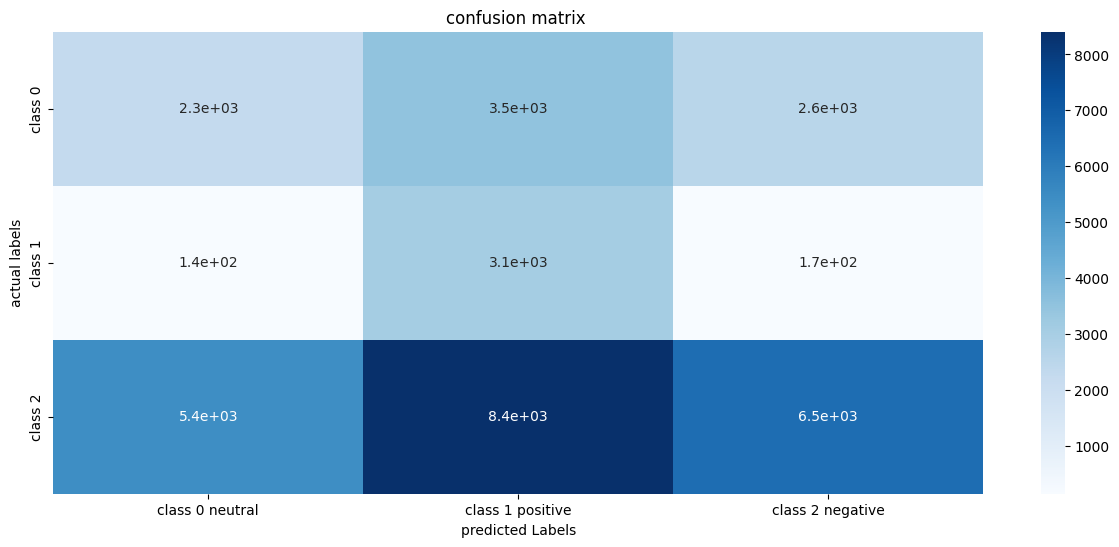

In [18]:
model_metrics(mnb_grid.best_estimator_, y_test, y_mnb_pred, best_mnb_params)

## LSTM model

In [19]:
def create_lstm_model(dropout_rate=0, epochs=5, batch_size=32):
    lstm_model = tf.keras.models.Sequential()
    lstm_model.add(Embedding(input_dim=5000, output_dim=32, input_length=214))
    lstm_model.add(LSTM(100))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(3, activation="softmax"))
    lstm_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    lstm_model.summary()
    return lstm_model

In [20]:
# # add callback to get training and validation metrics for each epoch
# from tensorflow.keras.callbacks import Callback

# class LossAccCallback(Callback):
#     def __init__(self):
#         self.losses = []
#         self.accuracy = []
#         self.val_losses = []
#         self.val_accuracy = []

#     def on_epoch_end(self, epoch, logs=None):
#         self.losses.append(logs["loss"])
#         self.accuracy.append(logs["accuracy"])
#         self.val_losses = logs.get("val_loss", None)
#         self.val_accuracy = logs.get("val_accuracy", None)
#         if "val_loss" and 'val_accuracy' in logs:
#             self.val_losses.append(logs[val_loss])
#             self.val_accuracy.append(logs[val_accuracy])

#     def plot_metrics(self):
#         epochs = np.arange(1, len(self.losses) + 1)
#         plt.figure(figsize=(10, 8))

#         print(len(self.val_losses))
#         print(len(self.losses))
#         print(len(self.val_accuracy))
#         print(len(self.accuracy))
        
#         plt.subplot(1, 2, 1)
#         plt.plot(epochs, self.val_losses, label="validation loss")
#         plt.plot(epochs, self.losses, label ='training loss')
#         plt.title("Training and Validation Loss")
#         plt.legend()

#         plt.subplot(1, 2, 2)
#         plt.plot(epochs, self.val_accuracy, label="validation accuracy")
#         plt.plot(epochs, self.accuracy, label ='training accuracy')
#         plt.title("Training and Validation Accuracy")
#         plt.xlabel("Epochs")
#         plt.ylabel("Accuracy")
#         plt.legend()

#         plt.tight_layout()
#         plt.show()

In [21]:
# from tensorflow.keras.callbacks import Callback
# class LossAccCallback(Callback):
    
#     def __init__(self):
#         self.losses = []
        

#     def on_epoch_end(self, epoch, logs={}):
#         self.losses.append(logs.get('loss'))
#         plt.plot(self.losses)
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.title('Training Loss')
#         plt.show()

In [22]:
# loss_history_callback = LossAccCallback()

In [23]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
lstm_model = KerasClassifier(
    model=create_lstm_model, dropout_rate=None, epochs=1, batch_size=None, verbose=1, callbacks=[loss_history_callback]
)

In [24]:
# param_grids = {
#     'dropout_rate': [0.0, 0.2, ],
#     'epochs': [5,10],
#     'batch_size': [32, 64]
# }

In [25]:
param_grids = {
    'dropout_rate': [0.0],
    'epochs': [3],
    'batch_size': [32],
    'class_weight': [class_weight_dict]
}

In [26]:
from sklearn.metrics import make_scorer
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=123)
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
lstm_grid = RandomizedSearchCV(
    estimator=lstm_model,
    param_distributions=param_grids,
    cv=kfold,
    scoring = scorers,
    verbose=1, error_score='raise',n_jobs=-1, refit='f1_score'
)

Start Time = 20:07:06
Fitting 2 folds for each of 1 candidates, totalling 2 fits


C:\ProgramData\anaconda3\envs\Capstone_Three_Project\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 214, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 213503 (834.00 KB)
Trainable params: 213503 (834.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3


3000/3000 [==============================] - ETA: 0s - loss: 0.4516 - accuracy: 0.7526

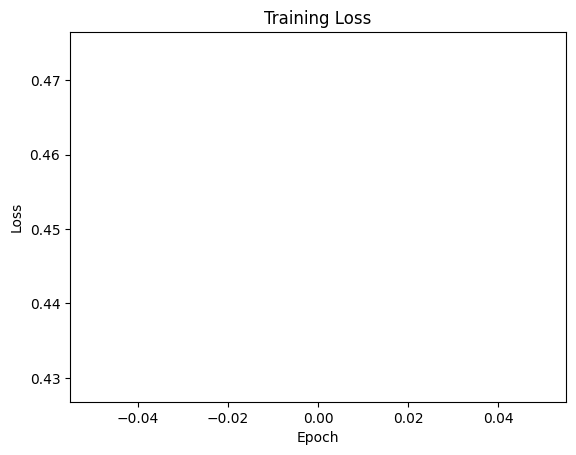

3000/3000 [==============================] - 247s 81ms/step - loss: 0.4516 - accuracy: 0.7526
Epoch 2/3
3000/3000 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9333

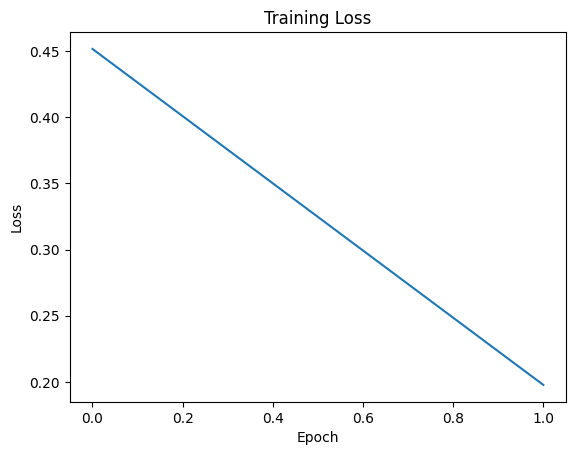

3000/3000 [==============================] - 244s 81ms/step - loss: 0.1977 - accuracy: 0.9333
Epoch 3/3
3000/3000 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.9465

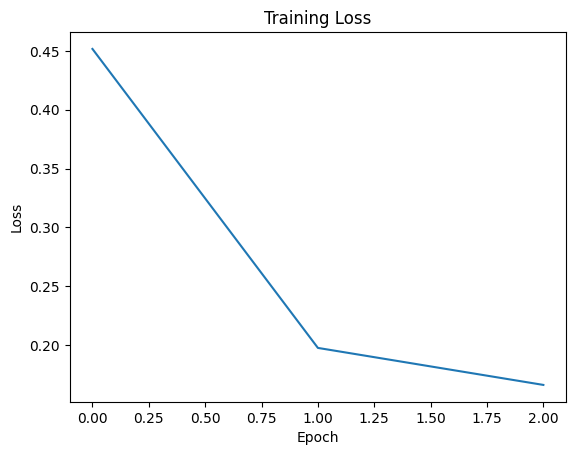

3000/3000 [==============================] - 245s 82ms/step - loss: 0.1662 - accuracy: 0.9465
End Time = 20:27:56


In [27]:
from datetime import datetime
print("Start Time =", datetime.now().strftime("%H:%M:%S"))
lstm_grid_result = lstm_grid.fit(
    X_train, y_train, batch_size=None,
    epochs=3,
    verbose=1,
   
)
print("End Time =", datetime.now().strftime("%H:%M:%S"))

In [ ]:
# from datetime import datetime
# print("Start Time =", datetime.now().strftime("%H:%M:%S"))
# lstm_grid_result = lstm_grid.fit(
#     X_train, y_train, batch_size=None,
#     epochs=3,
#     verbose=1,
#     callbacks=[LossAccCallback()],
# )
# print("End Time =", datetime.now().strftime("%H:%M:%S"))

In [ ]:
# callback = LossAccCallback()
# callback.plot_metrics()

1000/1000 [==============================] - 29s 29ms/step

 model performance:
Best hyperparameters: {'epochs': 3, 'dropout_rate': 0.0, 'class_weight': {0: 1.261499237764811, 1: 3.1545565085937755, 2: 0.529019173431653}, 'batch_size': 32}
Accuracy: 0.9540
Precision: 0.9468
Recall: 0.9536
F1-score: 0.9499

 KerasClassifier(
	model=<function create_lstm_model at 0x000001ED5BBBF2E0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=[<__main__.LossAccCallback object at 0x000001ED60531D10>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=3
	dropout_rate=0.0
	class_weight={0: 1.261499237764811, 1: 3.1545565085937755, 2: 0.529019173431653}
) Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      8321
           1       0.96      0.96      0.96      3384
           2       0.98      0.96      0.97 

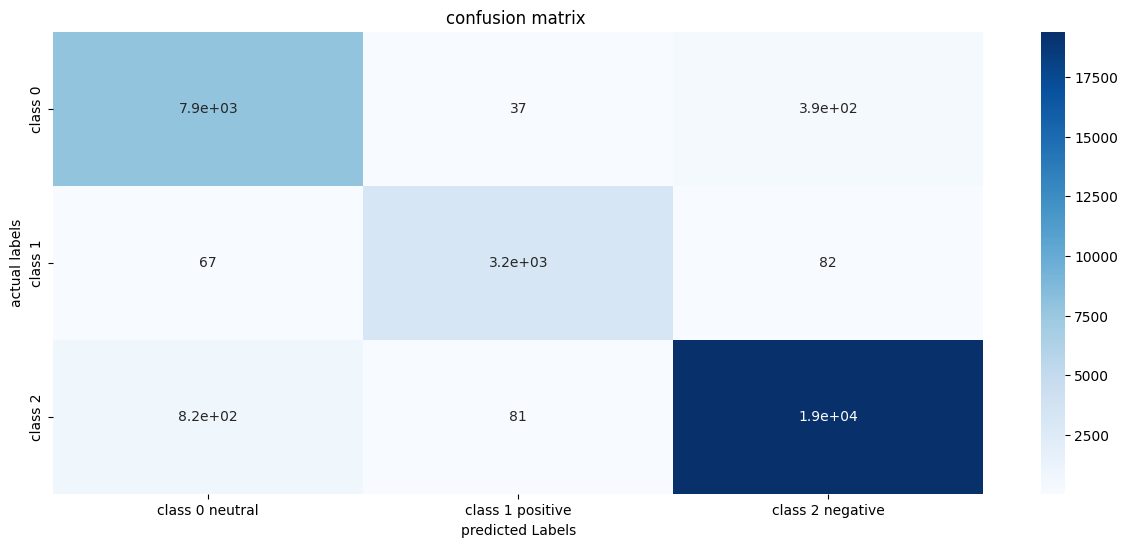

In [28]:
best_lstm_params = lstm_grid.best_params_
best_lstm_model = lstm_grid.best_estimator_
y_lstm_pred = best_lstm_model.predict(X_test)
model_metrics(best_lstm_model, y_test, y_lstm_pred, best_lstm_params)

In [29]:
best_lstm_model.keys()

AttributeError: 'KerasClassifier' object has no attribute 'keys'

In [30]:
training_loss = best_lstm_model.histroy['loss']

AttributeError: 'KerasClassifier' object has no attribute 'histroy'

## Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor()
random_grid = {
               'max_depth': [10],
               'max_features': ['auto'],
               'min_samples_leaf': [ 4],
               'n_estimators': [130]}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model

from datetime import datetime
print("Start Time =", datetime.now().strftime("%H:%M:%S"))
rf_random_result = rf_random.fit(
    X_train, y_train
)
print("End Time =", datetime.now().strftime("%H:%M:%S"))

best_rf_params = rf_random.best_params_
best_rf_model = rf_random.best_estimator_

y_rf_pred = best_rf_model.predict(X_test).round() 
model_metrics(best_rf_model, y_test, y_rf_pred, best_lstm_params)

In [ ]:
importances = best_rf_model.feature_importances_
indices = importances.argsort()[::-1]
for i in range(10):
    print(f"Feature {indices[i]}: {importances[indices[i]]:.4f}")


In [ ]:
feature_names = [f"feature {i}" for i in range(X_transformed.shape[1])]
len(feature_names)

In [ ]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Save The Best Model

In [ ]:
import joblib

In [ ]:
best_lstm_model = lstm_grid_result.best_estimator_
joblib.dump(best_lstm_model, '../Desktop/Capstone_Three_Project/models/best_lstm_model.joblib')

In [ ]:
load_model = joblib.load('best_lstm_model.joblib')

# Summary